### 02808 Personal Data Interaction for Mobile and Wearables

#### Agnes your skincare personal assistant


In this document you can find all the Python code, we needed to pre process the data for the `Insights` screen on our application
 * Laurine Dargaud s212803
 * Alexandra Polymenopoulou s212558
 * Thomas Spyrou s213161

In [85]:
# modules
import pandas as pd
import numpy as np
import ast
from functools import reduce
import operator
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass
from datetime import datetime
np.warnings.filterwarnings('ignore')

In [77]:
# load datasets
df_subroutines = pd.read_csv('data/routines.csv', sep=',')
df_products = pd.read_csv('data/products.csv', sep=',')
df_changes = pd.read_csv('data/changes.csv', sep=',')
progress = pd.read_csv("data/progress.csv")
active_ingredients = pd.read_csv("data/active_ingredients.csv")
active_products = pd.read_csv("data/active_products.csv")

In [7]:
# data processing of df_changes
df_changes['start_date'] = pd.to_datetime(df_changes['start_date'], format='%d/%m/%Y')
df_changes['end_date'] = pd.to_datetime(df_changes['end_date'], format='%d/%m/%Y')
df_changes = df_changes.drop('New Column', axis=1)
df_changes['change_id'] = df_changes.index
df_changes

,start_date,end_date,product_id,frequency_ampm,frequency_days,n_weeks,routine_id,change_id
0,2019-06-01,NaT,6,am,*,1,1,0
1,2019-06-01,2020-02-01,4,am,*,1,1,1
2,2019-06-01,NaT,7,am,*,1,1,2
3,2019-06-01,NaT,11,pm,*,1,2,3
4,2019-06-01,2020-02-01,4,pm,*,1,2,4
5,2019-06-01,NaT,10,pm,*,1,2,5
6,2019-06-01,NaT,9,pm,*,1,2,6
7,2019-06-01,2019-09-01,1,pm,[0; 2; 4],1,3,7
8,2019-06-01,NaT,8,pm,[1; 3; 5],1,4,8
9,2019-06-01,2021-05-01,3,am,[0],2,5,9


In [8]:
# create routine table
unique_dates = np.array(list(set(np.concatenate([df_changes['start_date'].values, df_changes['end_date'].values]))))
unique_dates = [d for d in unique_dates if pd.notna(d)]
unique_dates = list(sorted(unique_dates))

df_routines = pd.DataFrame(
    np.array([unique_dates, unique_dates[1:]+[np.nan]]).T,
    columns=['start_date','end_date']
)
df_routines

,start_date,end_date
0,2019-06-01,2019-09-01
1,2019-09-01,2020-02-01
2,2020-02-01,2021-05-01
3,2021-05-01,2021-06-08
4,2021-06-08,NaT


In [9]:
# detect "add product" change
def search_add_changes(row):
    adding_list = []
    for i, changeRow in df_changes.iterrows():
        if changeRow.start_date == row.start_date:
            adding_list.append(changeRow.change_id)
    return np.array(adding_list)

df_routines['adding'] = df_routines.apply(search_add_changes, axis=1)

In [10]:
# detect "remove product" change
def search_remove_changes(row):
    remove_list = []
    for i, changeRow in df_changes.iterrows():
        if changeRow.end_date == row.start_date:
            remove_list.append(changeRow.change_id)
    return np.array(remove_list)

df_routines['removing'] = df_routines.apply(search_remove_changes, axis=1)

In [13]:
# detect "modify frequency" change
def search_modify_change(row):
    adding_product_id = [df_changes.iloc[i].product_id for i in row.adding]
    removing_product_id = [df_changes.iloc[i].product_id for i in row.removing]
    common_product_id = np.intersect1d(adding_product_id, removing_product_id)
    modify_list = []
    adding_idx_toDelete, removing_idx_toDelete = [], []
    for aProductId in common_product_id:
        adding_idx = np.argwhere(adding_product_id == aProductId)[0][0]
        removing_idx = np.argwhere(removing_product_id == aProductId)[0][0]
        modify_list.append(np.array([row.adding[adding_idx], row.removing[removing_idx]]))
        adding_idx_toDelete.append(adding_idx)
        removing_idx_toDelete.append(removing_idx)
    return np.array(modify_list)

df_routines['modifying_freq'] = df_routines.apply(search_modify_change, axis=1)

In [14]:
# remove modifying_freq id from adding and removing lists
def update_adding_removing(row):
    if len(row.modifying_freq)>0:
        for aChange in row.modifying_freq:
            adding_id, removing_id = aChange
            row.adding = row.adding[row.adding != adding_id]
            row.removing = row.removing[row.removing != removing_id]
    return pd.Series(row)

df_routines = df_routines.apply(update_adding_removing, axis=1)

In [15]:
str(df_routines.iloc[-1].end_date)=='NaT'

True

In [16]:
def get_date_display(row): 
    if str(row.end_date)=='NaT':
        end_date = 'Now'
    else:
        end_date = row.end_date.strftime('%d/%m/%Y')
    return row.start_date.strftime('%d/%m/%Y') + ' - ' + end_date

df_routines['date_display'] = df_routines.apply(get_date_display, axis=1)

In [17]:
df_routines

,start_date,end_date,adding,removing,modifying_freq,date_display
0,2019-06-01,2019-09-01,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",[],[],01/06/2019 - 01/09/2019
1,2019-09-01,2020-02-01,[10],[7],[],01/09/2019 - 01/02/2020
2,2020-02-01,2021-05-01,"[11, 12]","[1, 4]",[],01/02/2020 - 01/05/2021
3,2021-05-01,2021-06-08,[13],[9],[],01/05/2021 - 08/06/2021
4,2021-06-08,NaT,[15],[13],"[[14, 10]]",08/06/2021 - Now


In [18]:
days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
ampm = {'am':'Morning', 'pm':'Evening'}

In [19]:
# process frequency output
def get_frequency_output(freq_days):
    if freq_days == '*':
        return 'Everyday'
    days_numbers = ast.literal_eval(freq_days.replace(';',','))
    days_txts = [days[n] for n in days_numbers]
    return ', '.join(days_txts)

def get_week_output(n_weeks):
    if n_weeks == 1:
        return 'Every week'
    return f'Every {n_weeks} weeks'

In [20]:
@dataclass
class Change:
    frequency: str
    product: str
    category: str
    brand: str

In [21]:
def get_routine_output(change_id):
    change_element = df_changes.iloc[change_id]
    freq_days = get_frequency_output(change_element.frequency_days)
    freq_am_pm = ampm[change_element.frequency_ampm]
    # frequency
    frequency = ' | '.join([freq_am_pm, freq_days])
    product_element = df_products[df_products.id == change_element.product_id].iloc[0]
    # product
    print()
    product = product_element['name'].title()
    # category
    category = product_element.category.title()
    # brand
    brand = product_element.brand.title()
    return Change(frequency, product, category, brand)

In [22]:
# create a new table of changes for routine display
# [routine_id, change_type, product, brand, category, frequency, frequency2 ]

changeRoutine_list = []

for i, row in df_routines.iterrows():
    # process adding
    for adding_id in row.adding:
        change = get_routine_output(adding_id)
        changeRoutine_list.append([
            i, 'add', change.product, change.brand, change.category, change.frequency, np.nan
        ])
    for remove_id in row.removing:
        change = get_routine_output(remove_id)
        changeRoutine_list.append([
            i, 'remove', change.product, change.brand, change.category, change.frequency, np.nan
        ])
    for changing_ids in row.modifying_freq:
        adding_id, removing_id = changing_ids
        change = get_routine_output(adding_id)
        new_freq = get_routine_output(removing_id).frequency
        changeRoutine_list.append([
            i, 'change', change.product, change.brand, change.category, change.frequency, new_freq
        ])

In [23]:
df_changeRoutine = pd.DataFrame(changeRoutine_list, columns=['completeRoutine_id','change_type', 'product', 'brand', 'category', 'frequency', 'new_frequency'])

In [24]:
df_changeRoutine.to_csv('data/changeRoutines.csv', index=False)

In [26]:
# find only routines in use
old_routines = set(df_changes[df_changes["end_date"].notna()].product_id)
active_routines = set(df_changes.product_id) - old_routines
active_routines

{5, 6, 7, 8, 9, 10, 11, 13}

In [29]:
active_products = df_products[df_products["id"].isin(active_routines)]
active_products # to be saved

,id,name,brand,category,photos,description,ingredients
4,5,Moisturizing Cream,CeraVe,moisturizing,NaN,Restore dry; uncomfortable skin with CeraVe Mo...,PURIFIED WATER; GLYCERIN; CETEARETH-20 AND CET...
5,6,Azelaic Acid 10% Suspension Brightening Cream,The Ordinary,serum,NaN,Create a uniform skin texture with The Ordinar...,WATER; ISODECYL NEOPENTANOATE; DIMETHICONE; AZ...
6,7,Ultra Sheer Liquid Sunscreen 50 SPF,Neutrogena,sunscreen,NaN,Dermatologist Recommended Brand\r\nBroad Spect...,HOMOSALATE; OCTOCRYLENE; OCTISALATE; OXYBENZON...
7,8,Glycolic Acid 7% Toning Solution,The Ordinary,toner,NaN,Glycolic Acid is an alpha hydroxy acid that ex...,WATER; GLYCOLIC ACID; ROSA DAMASCENA FLOWER WA...
8,9,Niacinamide 10% + Zinc 1%,The Ordinary,serum,NaN,Cleanse lifeless and clogged skin with Niacina...,NIACINAMIDE; WATER; PENTYLENE GLYCOL; ZINC PCA...
9,10,Brightening Rosehip Oil with Vitamin C 20ml,A'kin,oil,NaN,A 'kin Brightening Rosehip Oil with Vitamin C ...,ROSA CANINA SEED OIL; SOLANUM LYCOPERSICUM (TO...
10,11,Fresh Foaming Cleanser,Neutrogena,cleanser,NaN,A Make-Up Remover and Cleanser In One for Refr...,WATER; GLYCERIN; LAURYL GLUCOSIDE; DECYL GLUCO...
12,13,Vitamin C; B; E & Ferulic Serum,Biobare,serum,NaN,Scientifically-formulated with all-natural ing...,WATER; ETHOXYDIGLYCOL; L-ASCORBIC ACID; PROPYL...


In [30]:
active_products["ingredients"] = active_products["ingredients"].apply((lambda x: list(x.split(","))))

In [31]:
def remove_spaces(lst):
    after_process = []
    for item in lst:
        after_process.append(item.strip())
        
    return after_process

In [32]:
active_products.to_csv("data/active_products.csv", index=False)

In [34]:
# find products and ingredients in use (current routines)
active_products["ingredients"] = active_products["ingredients"].apply((lambda x: remove_spaces(x)))
ingredients = reduce(operator.concat, list(active_products["ingredients"]))
occurances = dict(Counter(ingredients))
occ_df = pd.DataFrame(list(occurances.items()), columns=["Name", "Count"])
occ_only_one = occ_df[occ_df["Count"] == 1].Count.count()
final_products = occ_df[occ_df["Count"] != 1]
final_products = pd.concat([final_products, pd.DataFrame([{"Name": "Others", "Count": occ_only_one}])], ignore_index = True, axis = 0)
# to be saved

In [35]:
final_products.to_csv("data/final_products.csv", index=False)

In [57]:
question_columns = ["Q1 - Acne scars", "Q2 - Pus-filled pimples",
           "Q3 - Pimples without pus", "Q4 - Deep nodules",
           "Q5 - Blackheads/Whiteheads", "Q6 - Redness", "Q7 - Pain"]

In [58]:
grade = ["Clearly less", "A bit less", "Less", "Same", "A bit more", "More", "Clearly more"]
grade_to_set = [-3, -2, -1, 0 , 1, 2, 3]

In [59]:
progress = progress.replace(grade, grade_to_set)

In [60]:
progress[question_columns] = progress[question_columns].astype(int)

In [61]:
progress["row_score"] = progress[question_columns].sum(axis=1)

In [62]:
progress

,date,is_first,Q1 - Acne scars,Q2 - Pus-filled pimples,Q3 - Pimples without pus,Q4 - Deep nodules,Q5 - Blackheads/Whiteheads,Q6 - Redness,Q7 - Pain,row_score,row_score_cumsum,Q1 - Acne scars_score,Q2 - Pus-filled pimples_score,Q3 - Pimples without pus_score,Q4 - Deep nodules_score,Q5 - Blackheads/Whiteheads_score,Q6 - Redness_score,Q7 - Pain_score
0,01/6/2019,1,7,2,5,5,6,8,2,35,0.648148,0.333333,0.888889,0.166667,0.777778,1.000000,0.428571,0.857143
1,15/08/2019,0,3,1,2,1,0,2,0,9,0.814815,0.666667,1.000000,0.500000,0.888889,1.000000,0.714286,0.857143
2,01/09/2019,0,3,0,3,1,0,2,1,10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,01/12/2019,0,-3,-3,-3,-3,-1,-3,-3,-19,0.648148,0.666667,0.666667,0.500000,0.666667,0.888889,0.571429,0.571429
4,01/03/2019,0,0,0,1,0,-2,1,0,0,0.648148,0.666667,0.666667,0.666667,0.666667,0.666667,0.714286,0.571429
5,01/04/2020,0,-2,-3,-1,-3,-2,-1,-3,-15,0.370370,0.444444,0.333333,0.500000,0.333333,0.444444,0.571429,0.142857
6,01/06/2020,0,-1,-3,-3,-3,-1,-1,-1,-13,0.129630,0.333333,0.000000,0.000000,0.000000,0.333333,0.428571,0.000000
7,01/07/2020,0,-1,0,0,0,-1,-3,0,-5,0.037037,0.222222,0.000000,0.000000,0.000000,0.222222,0.000000,0.000000
8,01/11/2020,0,-1,0,0,0,-1,0,0,-2,0.000000,0.111111,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000
9,01/06/2021,0,-1,0,2,0,-1,0,0,0,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000


In [63]:
progress["row_score_cumsum"] = progress["row_score"].cumsum()

In [64]:
for col in question_columns:
    progress[col + "_score"] = progress[col].cumsum()

In [65]:
score_columns = ["row_score_cumsum", "Q1 - Acne scars_score", "Q2 - Pus-filled pimples_score",
           "Q3 - Pimples without pus_score", "Q4 - Deep nodules_score",
           "Q5 - Blackheads/Whiteheads_score", "Q6 - Redness_score", "Q7 - Pain_score"]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

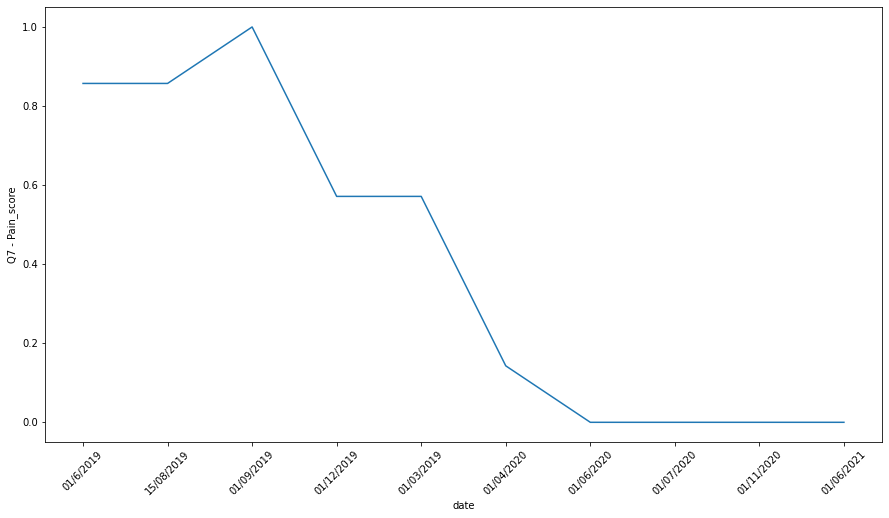

In [66]:
progress[score_columns] = progress[score_columns].transform(lambda x: (x - x.min())/ (x.max() - x.min()))
plt.figure(figsize = (15,8))
ax = sns.lineplot(data=progress, x="date", y="Q7 - Pain_score")
plt.xticks(rotation=45)

In [67]:
progress.to_csv("data/progress.csv", index=False)

In [68]:
complete_routine = pd.read_csv("completeRoutines.csv")
complete_routine

,start_date,end_date,adding,removing,modifying_freq
0,2019-06-01,2019-09-01,[0 1 2 3 4 5 6 7 8 9],[],[]
1,2019-09-01,2020-02-01,[10],[7],[]
2,2020-02-01,2021-05-01,[11 12],[1 4],[]
3,2021-05-01,2021-06-08,[13],[9],[]
4,2021-06-08,NaN,[15],[13],[[14 10]]


In [69]:
routine_rank = pd.DataFrame()
routine_rank["start_date"] = complete_routine.start_date
routine_rank["end_date"] = complete_routine.end_date
routine_rank

progress.date = pd.to_datetime(progress.date, format='%d/%m/%Y')
complete_routine.start_date = pd.to_datetime(complete_routine.start_date)
complete_routine.end_date = pd.to_datetime(complete_routine.end_date)

In [70]:
routine_counter = 0
df_routines_mean = pd.DataFrame()
for key, values in complete_routine.iterrows():
    df_ass_evaluation = progress[(progress.date < values.end_date) & (progress.date >= values.start_date)]
    df_ass_evaluation["routine_id"] = routine_counter
    routine_counter += 1
    df_routines_mean = df_routines_mean.append(df_ass_evaluation, ignore_index=True)

In [72]:
mean_df = df_routines_mean.groupby("routine_id").mean().reset_index()

In [73]:
mean_df["routine_dates"] = complete_routine["start_date"].astype(str) + " - " + complete_routine["end_date"].astype(str)
mean_df

,routine_id,is_first,Q1 - Acne scars,Q2 - Pus-filled pimples,Q3 - Pimples without pus,Q4 - Deep nodules,Q5 - Blackheads/Whiteheads,Q6 - Redness,Q7 - Pain,row_score,row_score_cumsum,Q1 - Acne scars_score,Q2 - Pus-filled pimples_score,Q3 - Pimples without pus_score,Q4 - Deep nodules_score,Q5 - Blackheads/Whiteheads_score,Q6 - Redness_score,Q7 - Pain_score,routine_dates
0,0,0.5,5.00,1.5,3.5,3.0,3.00,5.00,1.0,22.00,0.731481,0.500000,0.944444,0.333333,0.833333,1.000000,0.571429,0.857143,2019-06-01 - 2019-09-01
1,1,0.0,0.00,-1.5,0.0,-1.0,-0.50,-0.50,-1.0,-4.50,0.824074,0.833333,0.833333,0.750000,0.833333,0.944444,0.785714,0.785714,2019-09-01 - 2020-02-01
2,2,0.0,-1.25,-1.5,-1.0,-1.5,-1.25,-1.25,-1.0,-8.75,0.134259,0.277778,0.083333,0.125000,0.083333,0.277778,0.250000,0.035714,2020-02-01 - 2021-05-01
3,3,0.0,-1.00,0.0,2.0,0.0,-1.00,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,2021-05-01 - 2021-06-08


In [78]:
mean_df.to_csv("data/mean_df.csv")

In [79]:
progress = progress.drop(['is_first'], axis=1)

In [80]:
active_ingredients_without_others = active_ingredients.drop(active_ingredients[(active_ingredients.Name== 'Others')].index)

In [81]:
active_ingredients_without_others

,Name,Count
0,DIMETHICONE,2
1,WATER,4
2,LACTIC ACID,2
3,SALICYLIC ACID,2
4,SODIUM HYDROXIDE,2
5,GLYCERIN,2
6,ETHYLHEXYLGLYCERIN,2
7,CAPRYLYL GLYCOL,2
8,PHENOXYETHANOL,2


In [82]:
progress_stack = progress.melt(id_vars='date', value_vars=["Q1 - Acne scars_score", "Q2 - Pus-filled pimples_score", "Q3 - Pimples without pus_score", "Q4 - Deep nodules_score", "Q5 - Blackheads/Whiteheads_score", "Q6 - Redness_score", "Q7 - Pain_score", "row_score_cumsum"], 
            var_name='Category', value_name='Score', col_level=None, ignore_index=True)

In [83]:
progress_stack['day'] = progress_stack['date'].str[:2]
progress_stack['month'] = progress_stack['date'].str[3:5]
progress_stack['year'] = progress_stack['date'].str[6:]

In [84]:
progress_stack['date'] = pd.to_datetime(progress_stack['date'], format='%d/%m/%Y', errors='ignore')
type(progress_stack['date'][0])

pandas._libs.tslibs.timestamps.Timestamp